<a href="https://colab.research.google.com/github/hksantosh/eip/blob/master/tmp/PersonAttributes_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/EIP4/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
gdrive/  hvc_annotations.csv  model.png  resized/  sample_data/


In [2]:
%tensorflow_version 2.x

import os, cv2, json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Dense, SeparableConv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

TensorFlow 2.x selected.


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])        
        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [6]:
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=30)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [7]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
10297,resized/10299.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0
8668,resized/8669.jpg,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
1412,resized/1413.jpg,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
9059,resized/9060.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
9474,resized/9475.jpg,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0


In [8]:
val_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
3798,resized/3799.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
2784,resized/2785.jpg,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
3066,resized/3067.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0
10270,resized/10272.jpg,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
13566,resized/13568.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [10]:
# create train and validation data generators
#train_gen = PersonDataGenerator(train_df, batch_size=64)
train_gen = PersonDataGenerator(
    train_df, 
    batch_size=32, 
    augmentation=ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        preprocessing_function =
                    get_random_eraser(v_l=0, v_h=0, s_l=0.02, s_h=0.05, 
                                                 r_1=0.75, r_2=1/0.75, pixel_level=True)
    )
)

#valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)
valid_gen = PersonDataGenerator(
    val_df, 
    batch_size=32, 
    augmentation=ImageDataGenerator(
        rescale=1./255
    )
)

len(train_gen), len(valid_gen)

(360, 63)

In [11]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [12]:
images.shape, targets.get('gender_output').shape, targets.get('age_output').shape

((32, 224, 224, 3), (32, 2), (32, 5))

In [21]:
backbone = ResNet50(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3)),
    pooling='avg'
)

neck = backbone.output
#neck = Flatten(name="flatten")(neck)
neck = Dense(128, activation="relu")(neck)
neck = BatchNormalization()(neck)
neck = Dropout(0.06)(neck)


def build_tower(in_layer):
    neck = Dense(128, activation="relu")(in_layer)
    neck = BatchNormalization()(neck)
    neck = Dropout(0.03)(neck)
    return neck

def build_tower2(in_layer):
    neck = Dense(128, activation="relu")(in_layer)
    neck = BatchNormalization()(neck)
    neck = Dropout(0.04)(neck)
    neck = Dense(128, activation="relu")(neck)
    neck = BatchNormalization()(neck)
    neck = Dropout(0.02)(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

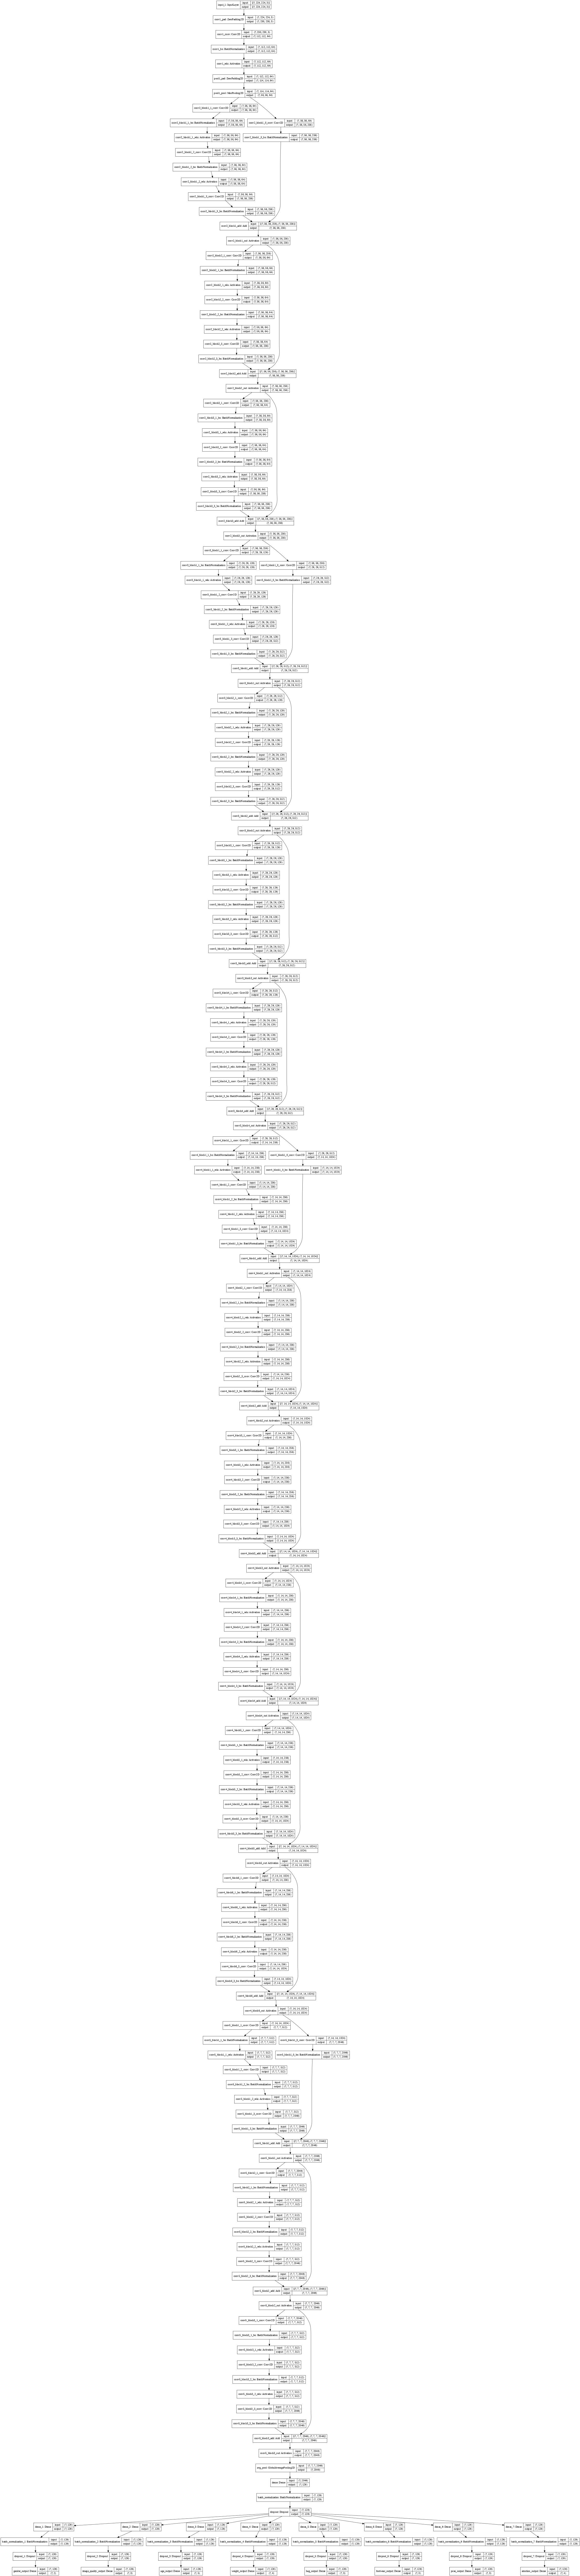

In [14]:
plot_model(model, show_shapes=True, dpi=50)

In [0]:
# monitor the learning rate
class LearningRateMonitor(Callback):
  # start of training
  def on_train_begin(self, logs={}):
    self.lrates = list()

  # end of each training epoch
  def on_epoch_end(self, epoch, logs={}):
    # get and store the learning rate
    optimizer = self.model.optimizer
    lrate = float(backend.get_value(self.model.optimizer.lr))
    print('Learning rate:', lrate)
    self.lrates.append(lrate)

In [0]:
model_path = '/content/gdrive/My Drive/EIP4/models/PersonAttributes_ResNet50_26Dec_1PM.h5'

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=model_path,
                             monitor='val_loss',
                             verbose=2,
                             save_best_only=True)

lrm = LearningRateMonitor()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.2), cooldown=0,
                               patience=8, min_lr=0.1e-7)

#callbacks = [checkpoint, lr_reducer, lr_scheduler]
callbacks = [checkpoint, lr_reducer, lrm]

In [0]:
losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",
 	"bag_output": "categorical_crossentropy",
 	"footwear_output": "categorical_crossentropy",
 	"pose_output": "categorical_crossentropy",
 	"emotion_output": "categorical_crossentropy"
}

loss_weights = {
    "gender_output": 1.0, "image_quality_output": 1.0, "age_output": 0.75, "weight_output": 0.75,
    "bag_output": 1.5,  "footwear_output": 1.5,  "pose_output": 1.0,  "emotion_output": 0.5
    }

opt = SGD(lr=0.01, momentum=0.8)
#opt = SGD(lr=0.01, momentum=0.9, decay=0.01)
model.compile(
    optimizer=opt,
    loss=losses,
    loss_weights=loss_weights,
    metrics=["accuracy"]
)

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
#    use_multiprocessing=True,
    workers=8, 
    epochs=200,
    callbacks=callbacks,
    verbose=2
)

  {'gender_output': '...', 'image_quality_output': '...', 'age_output': '...', 'weight_output': '...', 'bag_output': '...', 'pose_output': '...', 'footwear_output': '...', 'emotion_output': '...'}
    to  
  ['...', '...', '...', '...', '...', '...', '...', '...']
  {'gender_output': '...', 'image_quality_output': '...', 'age_output': '...', 'weight_output': '...', 'bag_output': '...', 'pose_output': '...', 'footwear_output': '...', 'emotion_output': '...'}
    to  
  ['...', '...', '...', '...', '...', '...', '...', '...']
Train for 360 steps, validate for 63 steps
Epoch 1/200

Epoch 00001: val_loss did not improve from 7.84248
Learning rate: 0.009999999776482582
360/360 - 90s - loss: 8.4301 - gender_output_loss: 0.7426 - image_quality_output_loss: 1.0539 - age_output_loss: 1.5348 - weight_output_loss: 1.0621 - bag_output_loss: 0.9938 - footwear_output_loss: 1.1246 - pose_output_loss: 1.0029 - emotion_output_loss: 1.0108 - gender_output_accuracy: 0.5216 - image_quality_output_accuracy